In [1]:
# !pip install tensorflow
# !pip install keras

In [2]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, normalize, Imputer, OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, LinearRegression, LogisticRegression, LassoCV, RidgeCV, SGDRegressor
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor

from sklearn.metrics import mean_squared_error

from imblearn.over_sampling import SMOTE

from keras.models import Sequential
from keras.optimizers import adam, SGD
from keras.activations import relu, sigmoid, softmax
from keras.layers import Dense
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [69]:
# load two data
df1 = pd.read_csv('data/otp.csv')
df2 = pd.read_excel('data/OTP_Time_Series_Master_Current_0719.xlsx')

In [70]:
df1.head()

,Route,Departing_Port,Arriving_Port,Airline,Month,Sectors_Scheduled,Sectors_Flown,Cancellations,Departures_On_Time,Arrivals_On_Time,Departures_Delayed,Arrivals_Delayed,Year,Month_Num
0,Adelaide-Brisbane,Adelaide,Brisbane,All Airlines,37987,155.0,155,0.0,123.0,120.0,32.0,35.0,2004,1
1,Adelaide-Canberra,Adelaide,Canberra,All Airlines,37987,75.0,75,0.0,72.0,72.0,3.0,3.0,2004,1
2,Adelaide-Gold Coast,Adelaide,Gold Coast,All Airlines,37987,40.0,40,0.0,36.0,35.0,4.0,5.0,2004,1
3,Adelaide-Melbourne,Adelaide,Melbourne,All Airlines,37987,550.0,548,2.0,478.0,487.0,70.0,61.0,2004,1
4,Adelaide-Perth,Adelaide,Perth,All Airlines,37987,191.0,191,0.0,169.0,168.0,22.0,23.0,2004,1


In [71]:
# df 1

# drop route column since we have it splitted into two columns (Departing_Port, Arriving_Port)
# drop Month columns since it is splitted into two columns (Year, Month_Num)
df1.drop(['Route', 'Month', 'Cancellations'], axis=1, inplace=True)

In [77]:
df2.head()

,Departing Port,Arriving Port,Airline,Sectors Scheduled,Sectors Flown,Departures On Time,Arrivals On Time,Departures Delayed,Arrivals Delayed,Month_Num,Year
0,Adelaide,Brisbane,Jetstar,30,30,25,24,5,6,1,2018
1,Adelaide,Gold Coast,Jetstar,40,40,34,35,6,5,1,2018
2,Adelaide,Melbourne,Jetstar,123,119,86,94,33,25,1,2018
3,Adelaide,Perth,Jetstar,30,30,19,25,11,5,1,2018
4,Adelaide,Sydney,Jetstar,142,135,107,115,28,20,1,2018


In [73]:
# df 2

# first, convert Month datatype (time-stamp) to string
df2['Month'] = df2['Month'].astype('str')
# split Month column into two columns (Month & Year) to match the first dataframe
df2['Month_Num'] = df2['Month'].str.split('-').str[1].str.lstrip('0')
df2['Year'] = df2['Month'].str.split('-').str[0]

# after modifying the columns as we wish, we will convert them to int data type

df2['Month_Num'] = df2['Month_Num'].astype(int)
df2['Year'] = df2['Year'].astype(int)

In [74]:
df2.columns

Index(['Route', 'Departing Port', 'Arriving Port', 'Airline', 'Month',
       'Sectors Scheduled', 'Sectors Flown', 'Cancellations',
       'Departures On Time', 'Arrivals On Time', 'Departures Delayed',
       'Arrivals Delayed', 'OnTime Departures \n(%)', 'OnTime Arrivals \n(%)',
       'Cancellations \n\n(%)', 'Month_Num', 'Year'],
      dtype='object')

In [76]:
# df 2

# drop route column since we have it splitted into two columns (Departing_Port, Arriving_Port)
# drop Month columns since it is splitted into two columns (Year, Month_Num)
df2.drop(['Route', 'Month', 'OnTime Departures \n(%)', 'OnTime Arrivals \n(%)', 'Cancellations',
          'Cancellations \n\n(%)'], axis=1, inplace=True)

In [78]:
# df2

# set df2 columns names to match df1 columns names setting
df2.columns = df2.columns.str.replace(' ', '_')

In [79]:
# check the shape of the data
df1.shape, df2.shape

((80615, 11), (10313, 11))

In [80]:
df2.Month_Num.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [81]:
# concatenate the two dataframes
df = pd.concat([df1, df2], axis=0, ignore_index=False, keys=None,
          levels=None, names=None, verify_integrity=False, copy=True)

/Users/Mohammed/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  This is separate from the ipykernel package so we can avoid doing imports until


In [82]:
# print info about data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90928 entries, 0 to 10312
Data columns (total 11 columns):
Airline               90928 non-null object
Arrivals_Delayed      90928 non-null float64
Arrivals_On_Time      90928 non-null float64
Arriving_Port         90928 non-null object
Departing_Port        90928 non-null object
Departures_Delayed    90923 non-null float64
Departures_On_Time    90928 non-null float64
Month_Num             90928 non-null int64
Sectors_Flown         90928 non-null int64
Sectors_Scheduled     90928 non-null float64
Year                  90928 non-null int64
dtypes: float64(5), int64(3), object(3)
memory usage: 8.3+ MB


In [83]:
# retrieve columns names
df.columns

Index(['Airline', 'Arrivals_Delayed', 'Arrivals_On_Time', 'Arriving_Port',
       'Departing_Port', 'Departures_Delayed', 'Departures_On_Time',
       'Month_Num', 'Sectors_Flown', 'Sectors_Scheduled', 'Year'],
      dtype='object')

In [84]:
# check for null values
df.isnull().sum()

Airline               0
Arrivals_Delayed      0
Arrivals_On_Time      0
Arriving_Port         0
Departing_Port        0
Departures_Delayed    5
Departures_On_Time    0
Month_Num             0
Sectors_Flown         0
Sectors_Scheduled     0
Year                  0
dtype: int64

In [85]:
# fill null value with the mean of the column
# df['Cancellations'].fillna(df['Cancellations'].mean(), inplace=True);
df['Departures_Delayed'].fillna(df['Departures_Delayed'].mean(), inplace=True);

In [86]:
# check for null values
df.isnull().sum()

Airline               0
Arrivals_Delayed      0
Arrivals_On_Time      0
Arriving_Port         0
Departing_Port        0
Departures_Delayed    0
Departures_On_Time    0
Month_Num             0
Sectors_Flown         0
Sectors_Scheduled     0
Year                  0
dtype: int64

In [87]:
# drop all null values
df.dropna(inplace=True)

In [88]:
df.describe()

,Arrivals_Delayed,Arrivals_On_Time,Departures_Delayed,Departures_On_Time,Month_Num,Sectors_Flown,Sectors_Scheduled,Year
count,90928.000000,90928.000000,90928.000000,90928.000000,90928.000000,90928.000000,90928.000000,90928.000000
mean,61.732382,281.884931,57.557033,286.065149,6.321221,343.618434,349.189865,2012.878706
std,415.289241,1845.712455,384.740318,1874.786132,3.426171,2245.180734,2280.903343,4.588466
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2004.000000
25%,6.000000,30.000000,6.000000,30.000000,3.000000,36.000000,36.000000,2009.000000
50%,14.000000,74.000000,14.000000,75.000000,6.000000,91.000000,92.000000,2014.000000
75%,32.000000,147.000000,31.000000,149.000000,9.000000,180.000000,183.000000,2017.000000
max,12840.000000,43291.000000,11933.000000,43537.000000,12.000000,49908.000000,50949.000000,2019.000000


In [89]:
# get numeric and categorical columns
numeric_columns = df.select_dtypes(include=np.number).columns.tolist()
categorical_columns = df.select_dtypes(include='object').columns.tolist()

In [90]:
# convert numeric columns to int data type
df[numeric_columns] = df[numeric_columns].apply(lambda x: x.astype(int))

In [91]:
# convert categorical values to lower case & strip any white space
df[categorical_columns] = df[categorical_columns].apply(lambda x: x.str.lower().str.strip())

In [92]:
# check data types
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90928 entries, 0 to 10312
Data columns (total 11 columns):
Airline               90928 non-null object
Arrivals_Delayed      90928 non-null int64
Arrivals_On_Time      90928 non-null int64
Arriving_Port         90928 non-null object
Departing_Port        90928 non-null object
Departures_Delayed    90928 non-null int64
Departures_On_Time    90928 non-null int64
Month_Num             90928 non-null int64
Sectors_Flown         90928 non-null int64
Sectors_Scheduled     90928 non-null int64
Year                  90928 non-null int64
dtypes: int64(8), object(3)
memory usage: 8.3+ MB


In [93]:
df.head()

,Airline,Arrivals_Delayed,Arrivals_On_Time,Arriving_Port,Departing_Port,Departures_Delayed,Departures_On_Time,Month_Num,Sectors_Flown,Sectors_Scheduled,Year
0,all airlines,35,120,brisbane,adelaide,32,123,1,155,155,2004
1,all airlines,3,72,canberra,adelaide,3,72,1,75,75,2004
2,all airlines,5,35,gold coast,adelaide,4,36,1,40,40,2004
3,all airlines,61,487,melbourne,adelaide,70,478,1,548,550,2004
4,all airlines,23,168,perth,adelaide,22,169,1,191,191,2004


# First: Univariate analysis (Investigate one feature every time)

### 1. Investigate and plot catergorical features

In [ ]:
def plot_value_counts(col_name):
    '''
        inputs:
           col_name :  column name from data(dataframe)
       return:
           a dataframe it columns are  : [ col_name, count, percent  ]
    '''
    
    ## 1- prepare dataframe to plot it 
    
    # build data frame from counts for thr given column
    values_count = pd.DataFrame(df[col_name].value_counts())
    # reset index to get 'race' as a column
    values_count.reset_index(inplace=True)
    # change columns names
    values_count.columns = [col_name,'count']
    # add a column with the percentage of each data point to the sum of all data points.
    values_count['percent'] = (values_count['count']/(values_count['count'].sum()) *100).round(2)
    
    

    ##2- plot data
    font_size = 20 - (.25 * len(values_count[col_name]))
    ax = values_count.plot(kind='bar',x=col_name, y='count', figsize=(15, 7), legend=True, fontsize=font_size)
    plt.xticks(rotation=45)
    ax.set_title(col_name.capitalize(), fontsize=30)
    ax.set_xlabel(col_name+' Types', fontsize=15)
    ax.set_ylabel("Count", fontsize=15)
    plt.show()
    
    return values_count

In [ ]:
for cat_col in categorical_columns:
    _ = plot_value_counts(cat_col)

### 2. Investigate and plot numerical features

In [ ]:
def plot_histogram(col_name):
    
    series = df[col_name]
    
    # remove zero values items [ indicates NA values.]

#     series = series[ series != 0 ]
    
    # get min amd max
    smin,smax = series.min(),series.max()
    
    # remove outliers for +- three standard deviations.
    threshold = 3 * series.std()
    series = series[ ~( (series - series.mean()).abs() > threshold ) ]
    
    # get percentiles (2.5%, 50%, 97.5%) of data
    percentiles = [ np.percentile(series,n) for n in (2.5,50,97.5) ]
    
    ax = series.plot(kind='hist',bins=100,figsize=(18,10),label='hist of '+col_name)
    plt.axvline(x=percentiles[0],color='r')
    plt.text(percentiles[0]-1,5,'2.5%',color='r',fontsize=20,rotation=45)
    plt.axvline(x=percentiles[2],color='r')
    plt.text(percentiles[2]-1,5,'95.5%',color='r',fontsize=20,rotation=45)
    plt.legend()
    ax.set_title('Histogram for {4:}\nmedian = {0:,.2f}\nmean = {1:,.2f}\nmin = {2:,}\nmax = {3:,}'.format(percentiles[1],series.mean(),smin,smax,col_name.capitalize().replace('.', ' '))
                 , fontsize=25)
    ax.set_xlabel(col_name.capitalize().replace('.', ' '), fontsize=18)
    ax.set_ylabel("Freq", fontsize=18)
    plt.show()

In [ ]:
print('Outliers above or below three standard deviations are excluded from the graph, mean and median calculations.')
for col in numeric_columns :
    plot_histogram( col )

# Second: Multivariate analysis (Investigate at least two features every time)

## Explore correlation between columns

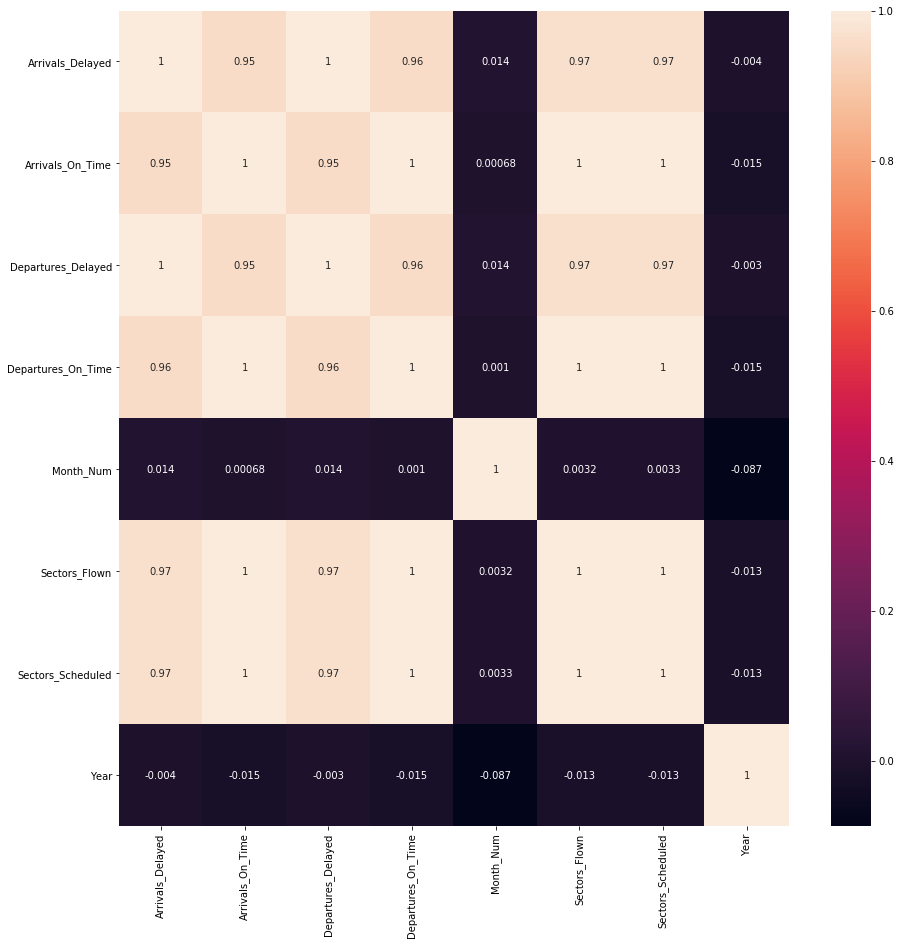

In [94]:
# plot heatop for columns correlations
corr = df.corr()
plt.figure(figsize=(15, 15))
sns.heatmap(corr, annot=True)
plt.show()

# predicting month and airline

In [95]:
my_df = df[['Airline', 'Month_Num', 'Departing_Port', 'Arriving_Port']]

In [ ]:
# dummify data
dummies_df = pd.get_dummies(my_df, drop_first=True)

In [ ]:
# get our X and y
X = my_df.drop(['Airline', 'Month_Num'], axis=1)
y = my_df[['Airline', 'Month_Num']]

# dummify
X = pd.get_dummies(X)
y = pd.get_dummies(y)

In [ ]:
# split data into train, test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# Standradize the data

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform (X_test)

In [ ]:
classifier = BaggingRegressor(RandomForestRegressor())
# classifier = SVR()
classifier.fit(X_train, y_train)

# model parameters
# param = {"n_jobs":[1, 2, 3]}
# gs_cv = GridSearchCV(classifier, param_grid=param, cv=)
# gs_cv.fit(X_train, y_train)


# cfs = cross_val_score(classifier, X_train, y_train, cv=5).mean()

y_hat = classifier.predict(X_test)
# y_proba = classifier.predict_proba(X_test)

print("Mean Square Error on test data is: ", mean_squared_error(y_test, y_hat))
print("Accuracy is: ", classifier.score(X_test, y_test))
# print("Mean Cross Vlas Score is: ",  cfs)

# Predicting Departures_On_Time, Arrivals_On_Time, Departures_Delayed, Arrivals_Delayed

In [96]:
# dummify data
dummies_df = pd.get_dummies(df, drop_first=True)

In [101]:
# get our X and y
X = dummies_df.drop(['Departures_On_Time', 'Arrivals_On_Time',
            'Departures_Delayed', 'Arrivals_Delayed', 'Sectors_Flown', 'Sectors_Scheduled', 'Year'], axis=1)
y = dummies_df[['Departures_Delayed', 'Arrivals_Delayed']]

In [100]:
df.drop(['Departures_On_Time', 'Arrivals_On_Time',
            'Departures_Delayed', 'Arrivals_Delayed', 'Sectors_Flown', 'Sectors_Scheduled', 'Year'], axis=1).head()

,Airline,Arriving_Port,Departing_Port,Month_Num
0,all airlines,brisbane,adelaide,1
1,all airlines,canberra,adelaide,1
2,all airlines,gold coast,adelaide,1
3,all airlines,melbourne,adelaide,1
4,all airlines,perth,adelaide,1


In [102]:
X.shape

(90928, 100)

In [103]:
y.shape

(90928, 2)

In [104]:
# split data into train, test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [105]:
X_train.shape, y_train.shape, y_test.shape

((72742, 100), (72742, 2), (18186, 2))

In [106]:
# Standradize the data

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform (X_test)

In [107]:
X_test.shape

(18186, 100)

In [ ]:
# LogisticRegression, LassoCV, RidgeCV
# from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
# from sklearn.multioutput import MultiOutputRegressor
# from sklearn.svm import SVR
# from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor

In [ ]:
classifier = MultiOutputRegressor(SVR())
classifier.fit(X_train, y_train)

# model parameters
# param = {"n_jobs":[1, 2, 3]}
# gs_cv = GridSearchCV(classifier, param_grid=param, cv=)
# gs_cv.fit(X_train, y_train)


# cfs = cross_val_score(classifier, X_train, y_train, cv=5).mean()

y_hat = classifier.predict(X_test)
# y_proba = classifier.predict_proba(X_test)

print("Mean Square Error on test data is: ", mean_squared_error(y_test, y_hat))
print("Accuracy is: ", classifier.score(X_test, y_test))
# print("Mean Cross Vlas Score is: ",  cfs)

/Users/Mohammed/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/Mohammed/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [ ]:
classifier.predict_proba(X_test)

In [ ]:
userInput_df = pd.DataFrame(columns=X.columns)

In [ ]:
# instantiate an empty list
l = []
# loop through the length of our empty dataframe
for i in list(userInput_df.columns):
    # append a value of 0 to the list
    l.append(0)

# plug the first row with 0s 'the list'
userInput_df.loc[1,:] = l

In [ ]:
X_test.shape

In [ ]:
userInput_df.shape

In [ ]:
userInput_df.Departing_Port_albury = 1
userInput_df.Arriving_Port_ballina = 1
userInput_df.Airline_qantas = 1
userInput_df.Sectors_Scheduled = 2
userInput_df.Sectors_Flown = 100


In [ ]:
userInput_df.shape

In [ ]:
a = scaler.transform(userInput_df)

In [ ]:
classifier.predict(a)

In [ ]:
classifier.predict(X_test)[2]

In [ ]:
# create dataframe with prediction
prediction_df = pd.DataFrame(columns=y.columns, data=classifier.predict(X_test), index=y_test.index)
prediction_df.head()

In [ ]:
# actuall y_test
y_test.head()

In [ ]:
# #  train nueral network

# model = Sequential()

# n_cols = X_train.shape[1]
# #add model layers
# model.add(Dense(252, activation='relu', input_shape=(n_cols,)))
# model.add(Dense(100, activation='relu'))
# model.add(Dense((4)))


# #compile model using mse as a measure of model performance
# model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])


# # set early stopping monitor so the model stops training when it won't improve anymore
# early_stopping_monitor = EarlyStopping(patience=3)
# #train model
# model.fit(X_train, y_train, validation_split=0.2, epochs=20, callbacks=[early_stopping_monitor])



# # predict
# # model.predict(X_test)

In [ ]:
model.predict(X_test)